<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/Psychometric_Functions_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
# calculations
import numpy as np

# model
import torch
import torch.nn as nn
import torch.nn.functional as F

# dataset and transformations
from skimage.draw import line_aa
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
from IPython import display

In [143]:
nImages  = 2000
imgSize = 30

images = torch.zeros(nImages, 1, imgSize, imgSize)
labels = torch.zeros(nImages)

for i in range(nImages):

    # create the gaussian noise
    G  = np.random.randn(imgSize, imgSize)

    # add a random bar randomly
    i1 = np.random.choice(np.arange(2, 28))
    i2 = np.random.choice(np.arange(2,6))

    if np.random.randn() > 0:
        G[i1:i1+i2,] = 1
    else:
        G[:,i1:i1+i2] = 1
        labels[i] = 1

    # add to the tensor with occlusion
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

labels = labels[:,None]

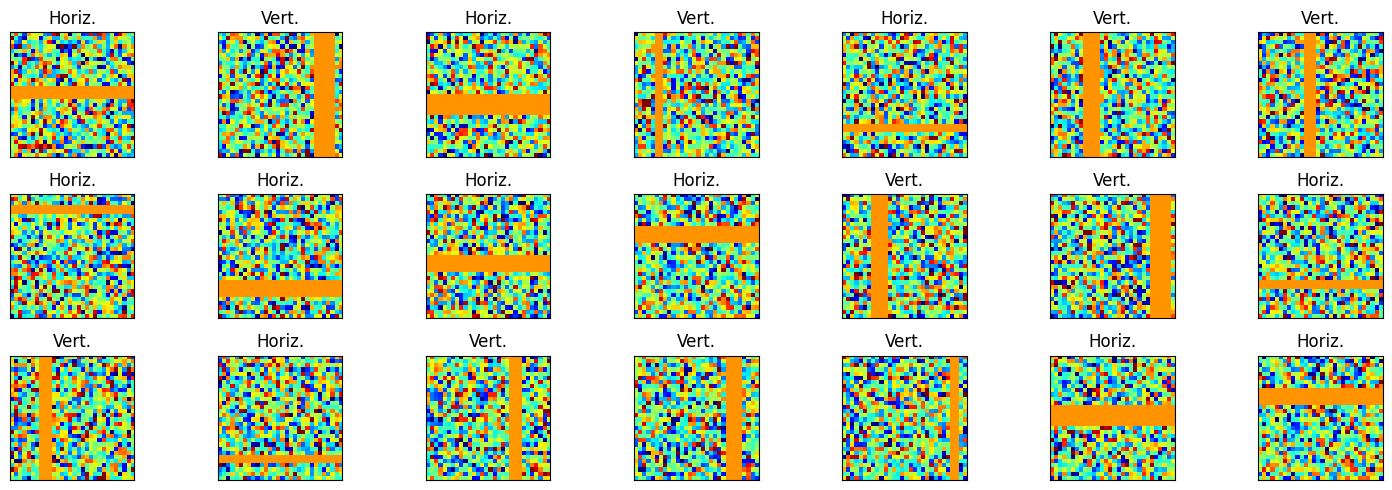

In [144]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(nImages)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-2,vmax=2,cmap='jet',extent=[-4,4,-4,4],origin='upper')

  title = 'Horiz.' if labels[whichpic].item()==0 else 'Vert.'
  ax.set_title(title)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [145]:
train_data, dev_data, train_labels, dev_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
dev_data  = TensorDataset(dev_data, dev_labels)

batchsize    = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader  = DataLoader(dev_data, batch_size=dev_data.tensors[0].shape[0])

In [146]:
# create a class for the model
def makeTheNet():

  class psychometricNet(nn.Module):
    def __init__(self):
      super().__init__()


      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1, 8, 3, padding=1, stride=1)
      # output size: (30+2*1-3)/1 + 1 = 30/2 = 15

      # second convolution layer
      self.conv2  = nn.Conv2d(8, 16, 3, stride=1)
      # output size: (15+2*0-3)/1 + 1 = 13/2 = 6

      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(6*6*16, 32)

      self.fc2 = nn.Linear(32, 1)



    def forward(self,x):

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x), 2)
      x = F.leaky_relu(x)

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x), 2)
      x = F.leaky_relu(x)

      # reshape for linear layer
      nUnits = x.shape.numel() / x.shape[0]
      x = x.view(-1, int(nUnits))

      # linear layers with batch normalization
      x = F.leaky_relu(self.fc1(x))                  # 1st layer
      x = F.leaky_relu(self.fc2(x))                  # 2nd layer

      return x

  # create the model instance
  net = psychometricNet()

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.AdamW(net.parameters(), lr=.001, weight_decay=5e-4)

  return net, lossfun, optimizer

In [147]:
# test the model with one batch
net, lossfun, optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

nOutput size:
torch.Size([32, 1])
 
Loss:
tensor(0.6970, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [162]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net, lossfun, optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      # convert output to probability via sigmoid

      yy = torch.sigmoid(yHat)

      # then we compute whether p>.5
      acc = torch.mean(((yy>.5).float().detach() == y).float())
      batchAcc.append( 100*acc.item() )               # add to list of accuracies
    # end of batch loop...

    # and get average losses and accuracy rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = np.mean(batchAcc)

    ### dev performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from dev dataloader

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # convert output to probability via sigmoid
    yy = torch.sigmoid(yHat)

    # then we compute whether p>.5
    acc = torch.mean(((yy>.5).float().detach() == y).float())
    devAcc[epochi]  = 100*acc.item()

  # end epochs

  # function output
  return trainLoss, trainAcc, devAcc, net

In [163]:
trainLoss, trainAcc, devAcc, net = function2trainTheModel()

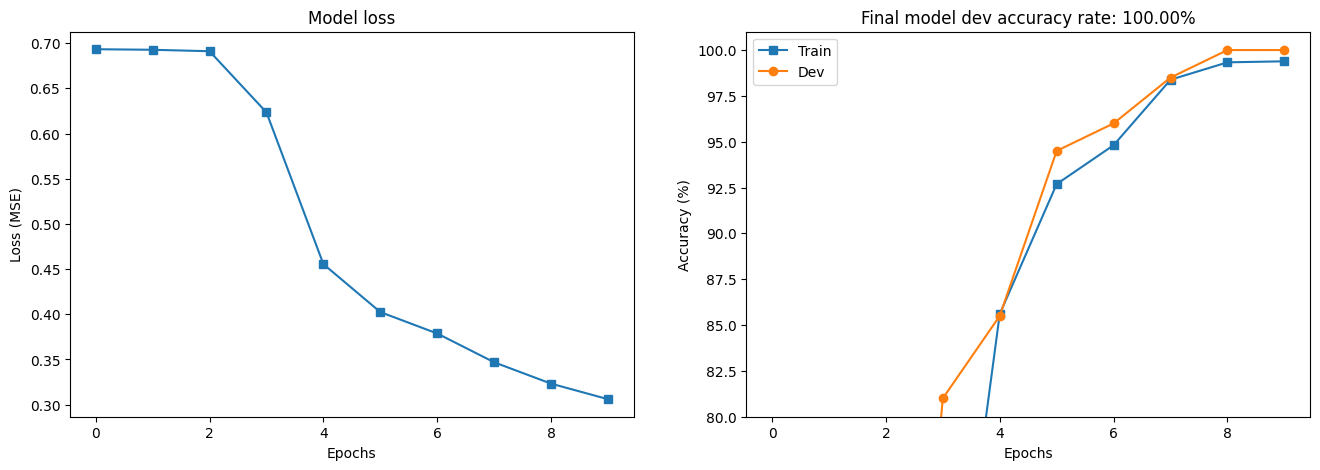

In [164]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim((80,101))
ax[1].set_title(f'Final model dev accuracy rate: {devAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

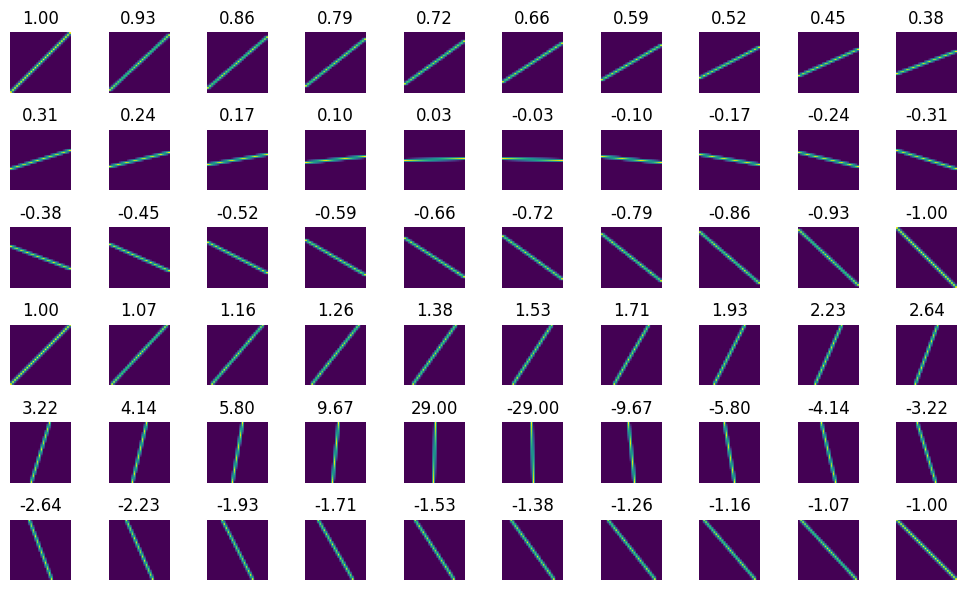

In [159]:
### create lines in images

from skimage.draw import line_aa

fig,ax = plt.subplots(6,10,figsize=(10,6))
imgs   = np.zeros((2*imgSize,1,imgSize,imgSize))
slopes = np.zeros(2*imgSize)

a = ax.flatten()
for i in range(imgSize):

  ### create lines with |slope|<1
  # point coords
  p1 = [0,i]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i,0,rows,cols] = val

  # plot
  a[i].imshow(imgs[i,0,:,:],origin='lower')
  a[i].set_title('%.2f'%slopes[i])
  a[i].axis('off')


  ### create lines with |slope|>1
  # point coords
  p1 = [i,0]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i+imgSize] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i+imgSize,0,rows,cols] = val

  # plot
  a[i+imgSize].imshow(imgs[i+imgSize,0,:,:],origin='lower')
  a[i+imgSize].set_title('%.2f'%slopes[i+imgSize])
  a[i+imgSize].axis('off')

plt.tight_layout()
plt.show()

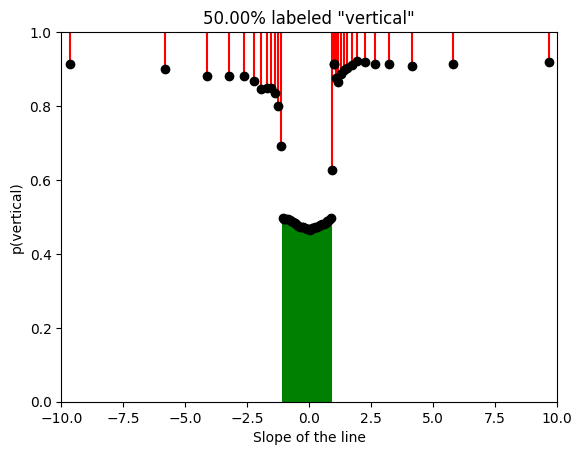

In [160]:
# run the images through the model

# randomly shuffle the images, just to be on the safe side...
# and also convert to tensor...
ridx = np.random.permutation(range(imgs.shape[0]))
imgT = torch.tensor(imgs[ridx,:,:,:].astype(np.float32))


# now generate the prediction (horizontal or vertical)
net.eval()
yHat = torch.sigmoid( net(imgT) ).detach()

# plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):
  if yHat[i]>.5:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[1,yHat[i]],'r')
  else:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[0,yHat[i]],'g')

plt.plot(slopes[ridx],yHat,'ko')
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title('%.2f%% labeled "vertical"' %torch.mean(100*(yHat>.5).float()).item())
plt.ylim([0,1])
plt.xlim([-10,10]) # note: this actually clips two data points
plt.show()

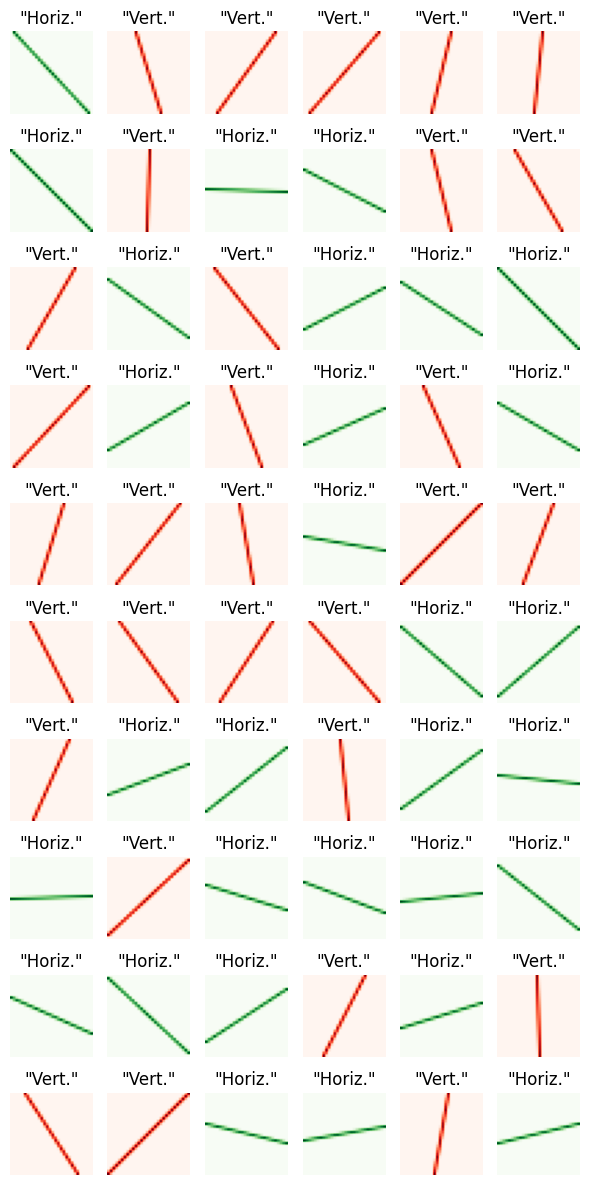

In [161]:
fig,ax = plt.subplots(10,6,figsize=(6,12))

for i,a in enumerate(ax.flatten()):

  # show the line-image (make sure to use the randomization index)
  if yHat[i]>.5:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Reds')
  else:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Greens')

  # and the title
  title = '"Vert."' if yHat[i].detach()>.5 else '"Horiz."'
  a.set_title(title)
  a.axis('off')

plt.tight_layout()
plt.show()